# <center> Итоговый проект первого года обучения
## <center> Прогнозирование победы команды в онлайн игре Dota 2
<center><img src=https://shared.akamai.steamstatic.com/store_item_assets/steam/apps/570/header.jpg>

## Постановка задачи

В условиях растущей популярности киберспорта и стремительного развития аналитических инструментов возрастает интерес к моделям, способным предсказывать исходы соревновательных матчей. Одной из таких дисциплин является многопользовательская онлайн-игра Dota 2, в которой на исход матча влияет множество факторов: выбор героев, взаимодействие между ними, состав команд и статистика игроков. 

В рамках данной работы ставится задача построения модели машинного обучения, предсказывающей результат матча Dota 2 на основе информации, известной до начала игры. Основными исходными данными являются пики героев, названия команд и историческая статистика, включая игровые роли героев, типы атаки, их скорости и другие характеристики. 

Задача формализуется как задача бинарной классификации, где модель должна определить вероятность победы одной из сторон (Radiant или Dire) по структурированным входным признакам. Данная задача может быть адаптирована также для других игр или спортивных состязаний.

Для решения данной задачи планируется:

1. провести сбор, очистку и агрегацию данных по матчам; Датасет собирался самостоятельно;

2. выполнить разведывательный анализ данных;

3. реализовать процесс инженерии признаков, включая синергию/интисинергию;

4. обучить и протестировать модели прогнозирования. Выбрать финальную модель и подобрать гиперпараметры для неё;

5. провести анализ важнейших факторов, влияющих на предсказание; сделать вывод о целесообразности модели;

6. cоздание пайплайна и подготовка модели к продакшэну;

7. сделать финальный вывод о выполненном проекте;

## Импорт необходимых библиотек

In [74]:
import numpy as np #для матричных вычислений
import pandas as pd #для анализа и предобработки данных
import matplotlib.pyplot as plt #для визуализации
import seaborn as sns #для визуализации
import os #для работы с windows
import pickle # Сохраняет и загружает Python-объекты (модели, данные)
from sklearn import linear_model #линейные модели
from sklearn import tree #деревья решений
from sklearn import ensemble #ансамбли
from sklearn import metrics #метрики
from sklearn import preprocessing #предобработка
from sklearn.model_selection import train_test_split #сплитование выборки
from sklearn.preprocessing import OneHotEncoder, MultiLabelBinarizer #кодировка
from scipy.sparse import hstack, csr_matrix #создание матриц
from lightgbm import LGBMClassifier #модель LGBM
from sklearn.metrics import make_scorer, f1_score, roc_auc_score, roc_curve, roc_auc_score, accuracy_score, classification_report #метрики
from sklearn.model_selection import GridSearchCV #подбор гиперпараметров
from sklearn.pipeline import Pipeline # Объединяет несколько шагов обработки в один поток
from sklearn.compose import ColumnTransformer # Применяет разные преобразования к разным колонкам
from sklearn.base import BaseEstimator, TransformerMixin # Базовые классы для создания своих преобразователей

## Загрузка и анализ структуры данных

* Сбор данных выполнялся самостоятельно используя https://api.opendota.com/api/ и прокси
* Датасет включает в себя результаты матчей в ДОТА 2 с января 2024 года по май 2025 года
* Ноутбук парсер dota_database.ipynb приложен к данному проекту
* Спарсенные данные в формате csv

In [75]:
combined_df = pd.read_csv('data/combined_matches_data.csv')
combined_df.head()

,match_id,date,tournament,radiant_team,dire_team,game_patch,rad_winner,radiant_player_1_name,radiant_hero_1_primary_attr,radiant_hero_1_attack_type,...,radiant_hero_1_localized_name,radiant_hero_2_localized_name,radiant_hero_3_localized_name,radiant_hero_4_localized_name,radiant_hero_5_localized_name,dire_hero_1_localized_name,dire_hero_2_localized_name,dire_hero_3_localized_name,dire_hero_4_localized_name,dire_hero_5_localized_name
0,8311804395,2025-05-28 18:01:00,DreamLeague Season 26,Gaimin Gladiators,Team Liquid,7.39,1,полумрак,agi,Ranged,...,Clinkz,Oracle,Kunkka,Keeper of the Light,Storm Spirit,Bane,Beastmaster,Void Spirit,Tusk,Gyrocopter
1,8311769675,2025-05-28 17:31:34,Ultras Dota Pro League 2024-25,Air Defence,Team Yakuza,7.39,1,&,str,Melee,...,Spirit Breaker,Witch Doctor,Tinker,Undying,Razor,Shadow Shaman,Templar Assassin,Earthshaker,Pudge,Juggernaut
2,8311713871,2025-05-28 17:00:03,DreamLeague Season 26,Team Liquid,Gaimin Gladiators,7.39,1,Kaladin Stormblessed,str,Melee,...,Undying,Brewmaster,Batrider,Marci,Drow Ranger,Monkey King,Shadow Shaman,Medusa,Tusk,Queen of Pain
3,8311668790,2025-05-28 16:06:18,Ultras Dota Pro League 2024-25,Team Yakuza,Romashku,7.39,1,sato,int,Ranged,...,Tinker,Dawnbreaker,Invoker,Alchemist,Monkey King,Jakiro,Troll Warlord,Void Spirit,Batrider,Primal Beast
4,8311578960,2025-05-28 15:16:35,Ultras Dota Pro League 2024-25,Romashku,Team Yakuza,7.39,0,Keyleth,agi,Ranged,...,Razor,Shadow Shaman,Spirit Breaker,Queen of Pain,Kunkka,Dark Willow,Tiny,Nature's Prophet,Morphling,Earthshaker


In [76]:
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33981 entries, 0 to 33980
Data columns (total 67 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   match_id                       33981 non-null  int64  
 1   date                           33981 non-null  object 
 2   tournament                     33981 non-null  object 
 3   radiant_team                   32892 non-null  object 
 4   dire_team                      32789 non-null  object 
 5   game_patch                     33981 non-null  float64
 6   rad_winner                     33981 non-null  int64  
 7   radiant_player_1_name          33917 non-null  object 
 8   radiant_hero_1_primary_attr    33981 non-null  object 
 9   radiant_hero_1_attack_type     33981 non-null  object 
 10  radiant_hero_1_roles           33981 non-null  object 
 11  radiant_hero_1_move_speed      33981 non-null  int64  
 12  radiant_player_2_name          33880 non-null 

Датасет содержит 67 признаков и данные по 33981 матчам. Ниже показаны текстовые описания всех признаков в датасете

**🏷️ Основная информация о матче**
| Признак        | Описание                                                     |
| -------------- | ------------------------------------------------------------ |
| `match_id`     | Уникальный идентификатор матча.                              |
| `date`         | Дата и время начала матча (формат: YYYY-MM-DD HH\:MM\:SS).   |
| `tournament`   | Название турнира, в рамках которого проводился матч.         |
| `radiant_team` | Название команды, игравшей за сторону Radiant.               |
| `dire_team`    | Название команды, игравшей за сторону Dire.                  |
| `game_patch`   | Версия патча Dota 2, в котором был сыгран матч.              |
| `rad_winner`   | Победа Radiant: `1` — Radiant победили, `0` — Dire победили. |



**👥 Игроки и герои Radiant**
| Признак                             | Описание                                                                   |
| ----------------------------------- | -------------------------------------------------------------------------- |
| `radiant_player_[1-5]_name`         | Никнейм игрока Radiant на соответствующей позиции.                         |
| `radiant_hero_[1-5]_primary_attr`   | Основной атрибут героя: `str` (сила), `agi` (ловкость), `int` (интеллект). |
| `radiant_hero_[1-5]_attack_type`    | Тип атаки: `Melee` — ближняя, `Ranged` — дальняя.                          |
| `radiant_hero_[1-5]_localized_name` | Отображаемое имя героя на английском языке.                                |
| `radiant_hero_[1-5]_roles`          | Роли героя в игре.                                                         |
| `radiant_hero_[1-5]_move_speed`     | Скорость героя.                                                            |


**👥 Игроки и герои Dire**
| Признак                          | Описание                                        |
| -------------------------------- | ----------------------------------------------- |
| `dire_player_[1-5]_name`         | Никнейм игрока Dire на соответствующей позиции. |
| `dire_hero_[1-5]_primary_attr`   | Основной атрибут героя.                         |
| `dire_hero_[1-5]_attack_type`    | Тип атаки героя.                                |
| `dire_hero_[1-5]_localized_name` | Отображаемое имя героя на английском языке.     |
| `dire_hero_[1-5]_roles`          | Роли героя в игре.                              |
| `dire_hero_[1-5]_move_speed`     | Скорость героя.                                 |

In [77]:
combined_df.describe()

,match_id,game_patch,rad_winner,radiant_hero_1_move_speed,radiant_hero_2_move_speed,radiant_hero_3_move_speed,radiant_hero_4_move_speed,radiant_hero_5_move_speed,dire_hero_1_move_speed,dire_hero_2_move_speed,dire_hero_3_move_speed,dire_hero_4_move_speed,dire_hero_5_move_speed
count,3.398100e+04,33981.000000,33981.000000,33981.000000,33981.000000,33981.000000,33981.000000,33981.000000,33981.000000,33981.000000,33981.000000,33981.000000,33981.000000
mean,7.985517e+09,7.367517,0.510373,299.720726,298.955151,299.423796,299.319326,298.934257,299.762956,299.068156,299.480004,299.420264,298.999882
std,2.017733e+08,0.009995,0.499900,14.634099,13.806584,13.687978,13.849870,14.111282,14.705382,13.889667,13.709669,13.944394,14.199957
min,7.538143e+09,7.350000,0.000000,275.000000,275.000000,275.000000,275.000000,275.000000,275.000000,275.000000,275.000000,275.000000,275.000000
25%,7.818490e+09,7.360000,0.000000,290.000000,290.000000,290.000000,290.000000,290.000000,290.000000,290.000000,290.000000,290.000000,290.000000
50%,7.987498e+09,7.370000,1.000000,300.000000,295.000000,295.000000,295.000000,295.000000,300.000000,295.000000,295.000000,295.000000,295.000000
75%,8.169559e+09,7.370000,1.000000,310.000000,310.000000,310.000000,310.000000,310.000000,310.000000,310.000000,310.000000,310.000000,310.000000
max,8.311804e+09,7.390000,1.000000,330.000000,330.000000,330.000000,330.000000,330.000000,330.000000,330.000000,330.000000,330.000000,330.000000


In [78]:
combined_df.describe(include=['object'])

,date,tournament,radiant_team,dire_team,radiant_player_1_name,radiant_hero_1_primary_attr,radiant_hero_1_attack_type,radiant_hero_1_roles,radiant_player_2_name,radiant_hero_2_primary_attr,...,radiant_hero_1_localized_name,radiant_hero_2_localized_name,radiant_hero_3_localized_name,radiant_hero_4_localized_name,radiant_hero_5_localized_name,dire_hero_1_localized_name,dire_hero_2_localized_name,dire_hero_3_localized_name,dire_hero_4_localized_name,dire_hero_5_localized_name
count,33981,33981,32892,32789,33917,33981,33981,33981,33880,33981,...,33981,33981,33981,33981,33981,33981,33981,33981,33981,33981
unique,33921,213,1534,1639,2827,4,2,102,3149,4,...,125,125,125,125,126,125,125,125,125,125
top,2024-07-14 12:30:00,Destiny League,Dominion,Foxy gaming,необучаемая,agi,Ranged,"Carry,Escape",необучаемая,str,...,Tiny,Tiny,Rubick,Rubick,Crystal Maiden,Tiny,Tiny,Rubick,Rubick,Crystal Maiden
freq,3,6434,704,711,487,10560,17891,1565,477,10953,...,842,945,789,1308,1144,866,977,809,1296,1237


## Предобработка, очистка данных

Проверим датасет на наличие дубликатов

In [79]:
dupl_columns = list(combined_df.columns)

mask = combined_df.duplicated(subset=dupl_columns)
combined_df_duplicates = combined_df[mask]
print(f'Число найденных дубликатов: {combined_df_duplicates.shape[0]}')

Число найденных дубликатов: 0


Проверим наличие пропусков

In [80]:
cols_null_percent = combined_df.isnull().mean() * 100
cols_with_null = cols_null_percent[cols_null_percent>0].sort_values(ascending=False)
display(cols_with_null)

dire_team                3.507843
radiant_team             3.204732
radiant_player_5_name    0.397281
dire_player_1_name       0.367853
dire_player_5_name       0.341367
dire_player_4_name       0.320767
dire_player_2_name       0.308996
radiant_player_2_name    0.297225
radiant_player_3_name    0.256025
radiant_player_4_name    0.253083
dire_player_3_name       0.241311
radiant_player_1_name    0.188341
dtype: float64

Заполним пропуски по командам:

In [81]:
UNKNOWN_TEAM = '__UNKNOWN_TEAM__'

combined_df['radiant_team'] = combined_df['radiant_team'].fillna(UNKNOWN_TEAM)
combined_df['dire_team'] = combined_df['dire_team'].fillna(UNKNOWN_TEAM)

Удалим все строки, где есть хотя бы один пропуск в остальных колонках - где пропуски менее 1%

In [82]:
columns_with_na = [
    'radiant_player_5_name', 'dire_player_1_name', 'dire_player_5_name',
    'dire_player_4_name', 'dire_player_2_name', 'radiant_player_2_name',
    'radiant_player_3_name', 'radiant_player_4_name', 'dire_player_3_name',
    'radiant_player_1_name'
]
df_cleaned = combined_df.dropna(subset=columns_with_na)

total_missing_values = df_cleaned.isnull().sum().sum()


print(f'Общее кличество пропусков: {total_missing_values}')
print(f'Результирующее число записей: {df_cleaned.shape[0]}')

Общее кличество пропусков: 0
Результирующее число записей: 33450


Рассмотрим неинформативные признаки

In [83]:
low_information_cols = [] 

#цикл по всем столбцам
for col in df_cleaned.columns:
    #наибольшая относительная частота в признаке
    top_freq = df_cleaned[col].value_counts(normalize=True).max()
    #доля уникальных значений от размера признака
    nunique_ratio = df_cleaned[col].nunique() / df_cleaned[col].count()
    # сравниваем наибольшую частоту с порогом
    if top_freq > 0.95:
        low_information_cols.append(col)
        print(f'{col}: {round(top_freq*100, 2)}% одинаковых значений')
    # сравниваем долю уникальных значений с порогом
    if nunique_ratio > 0.95:
        low_information_cols.append(col)
        print(f'{col}: {round(nunique_ratio*100, 2)}% уникальных значений')

match_id: 100.0% уникальных значений
date: 99.82% уникальных значений


Удалим признак match_id, так как это просто иденитификатор матча, и не несет в себе нужную информацию

In [84]:
df_cleaned = df_cleaned.drop(columns=['match_id'])

Признак date преобразуем в формат datetime; далее из признака date выделим год, месяц, день, день недели

In [85]:
df_cleaned['date'] = pd.to_datetime(df_cleaned['date'], format='%Y-%m-%d %H:%M:%S')
df_cleaned['match_year'] = df_cleaned['date'].dt.year
df_cleaned['match_month'] = df_cleaned['date'].dt.month
df_cleaned['match_day'] = df_cleaned['date'].dt.day
df_cleaned['match_dayofweek'] = df_cleaned['date'].dt.dayofweek

Работа с выбросами

In [86]:
# описание числовых признаков
df_cleaned.describe()

,date,game_patch,rad_winner,radiant_hero_1_move_speed,radiant_hero_2_move_speed,radiant_hero_3_move_speed,radiant_hero_4_move_speed,radiant_hero_5_move_speed,dire_hero_1_move_speed,dire_hero_2_move_speed,dire_hero_3_move_speed,dire_hero_4_move_speed,dire_hero_5_move_speed,match_year,match_month,match_day,match_dayofweek
count,33450,33450.000000,33450.000000,33450.000000,33450.000000,33450.000000,33450.000000,33450.000000,33450.000000,33450.000000,33450.000000,33450.000000,33450.000000,33450.000000,33450.000000,33450.000000,33450.000000
mean,2024-10-16 01:42:24.912765440,7.367438,0.510643,299.733034,298.949776,299.416442,299.328251,298.947683,299.766368,299.065471,299.481465,299.400000,299.007324,2024.340120,5.900688,16.291689,2.880747
min,2024-01-14 23:10:27,7.350000,0.000000,275.000000,275.000000,275.000000,275.000000,275.000000,275.000000,275.000000,275.000000,275.000000,275.000000,2024.000000,1.000000,1.000000,0.000000
25%,2024-06-27 19:30:35.249999872,7.360000,0.000000,290.000000,290.000000,290.000000,290.000000,290.000000,290.000000,290.000000,290.000000,290.000000,290.000000,2024.000000,3.000000,10.000000,1.000000
50%,2024-10-12 13:11:48,7.370000,1.000000,300.000000,295.000000,295.000000,295.000000,295.000000,300.000000,295.000000,295.000000,295.000000,295.000000,2024.000000,5.000000,16.000000,3.000000
75%,2025-02-10 04:37:46.249999872,7.370000,1.000000,310.000000,310.000000,310.000000,310.000000,310.000000,310.000000,310.000000,310.000000,310.000000,310.000000,2025.000000,9.000000,24.000000,4.000000
max,2025-05-28 18:01:00,7.390000,1.000000,330.000000,330.000000,330.000000,330.000000,330.000000,330.000000,330.000000,330.000000,330.000000,330.000000,2025.000000,12.000000,31.000000,6.000000
std,NaN,0.009931,0.499894,14.635308,13.803929,13.690085,13.843237,14.126069,14.718602,13.891346,13.715527,13.947748,14.215946,0.473756,3.214524,8.514192,1.971434


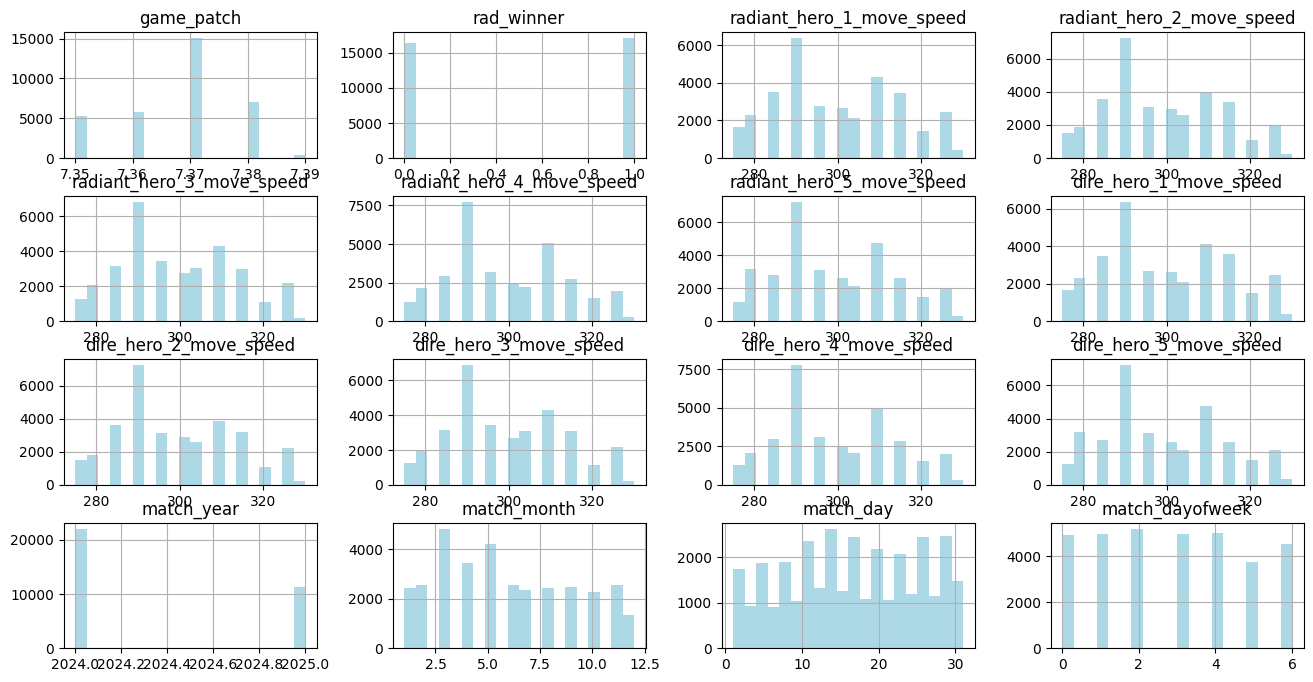

In [87]:
# список с названием числовых признаков
num_col_list = df_cleaned.select_dtypes(include='number').columns.to_list()

# гистограммы числовых признакав для первичной визуальной оценки
df_cleaned[num_col_list].hist(figsize=(16, 8), color='lightblue', bins=20);

Числовые данные выглядят отлично от нормальных

Проверим выбросы по методу Тьюки

In [88]:
# Выбираем числовые признаки
num_cols = df_cleaned.select_dtypes(include='number').columns

# Подсчёт выбросов по IQR
outlier_counts = {}

for col in num_cols:
    Q1 = df_cleaned[col].quantile(0.25)
    Q3 = df_cleaned[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    count_outliers = ((df_cleaned[col] < lower) | (df_cleaned[col] > upper)).sum()
    outlier_counts[col] = count_outliers

# Вывод количества выбросов по признакам
print("Количество выбросов по признакам:")
for col, count in sorted(outlier_counts.items(), key=lambda x: -x[1]):
    print(f"{col}: {count} выбросов")

Количество выбросов по признакам:
game_patch: 326 выбросов
rad_winner: 0 выбросов
radiant_hero_1_move_speed: 0 выбросов
radiant_hero_2_move_speed: 0 выбросов
radiant_hero_3_move_speed: 0 выбросов
radiant_hero_4_move_speed: 0 выбросов
radiant_hero_5_move_speed: 0 выбросов
dire_hero_1_move_speed: 0 выбросов
dire_hero_2_move_speed: 0 выбросов
dire_hero_3_move_speed: 0 выбросов
dire_hero_4_move_speed: 0 выбросов
dire_hero_5_move_speed: 0 выбросов
match_year: 0 выбросов
match_month: 0 выбросов
match_day: 0 выбросов
match_dayofweek: 0 выбросов


In [89]:
# Подсчёт количества матчей по game_patch
patch_counts = df_cleaned["game_patch"].value_counts().sort_index()
patch_counts

game_patch
7.35     5272
7.36     5736
7.37    15058
7.38     7058
7.39      326
Name: count, dtype: int64

Выброс по game_patch объясняется с ещё ненакопившимися данными по патчу 7.39, пока оставим этот признак, возможно он нам пригодится, остальные выбросы отстутствуют.

## Разведывательный анализ данных и Feature Engineering

Распределение целевой переменной

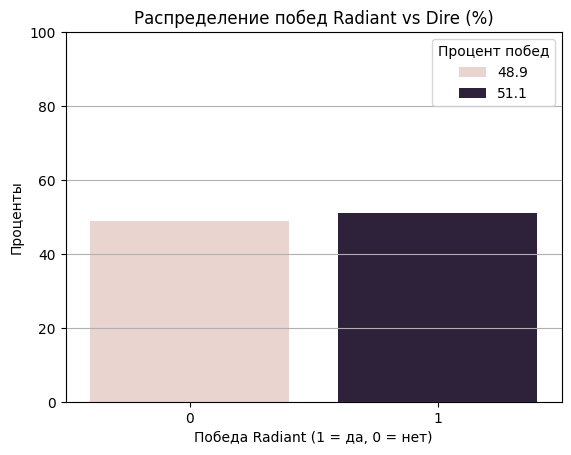

In [90]:
counts = df_cleaned['rad_winner'].value_counts(normalize=True) * 100
counts = counts.round(1)
plot_df = counts.reset_index()
plot_df.columns = ['rad_winner', 'percent']

# Построение графика
ax = sns.barplot(data=plot_df, x='rad_winner', y='percent', hue='percent')
plt.title("Распределение побед Radiant vs Dire (%)")
plt.xlabel("Победа Radiant (1 = да, 0 = нет)")
plt.ylabel("Проценты")
plt.ylim(0, 100)
plt.grid(axis='y')
plt.legend(title="Процент побед", loc='upper right')
plt.show()

Распределение целевой переменной равномерное и сбалансированное, есть небольшое преимущество в победах у команд Radiant в 2%, в большей половине случаев выигрывает команда Radiant (51.1%)

Проведем статистический тест для нашего наблюдения. Сформулируем нулевую и альтернативные гипотезы:

*Нулевая гипотеза*: p ≤ 0.5 (Процент побед Radiant не больше 50%. Преимущества нет).

*Альтернативная гипотеза*: p > 0.5 (Процент побед Radiant статистически значимо больше 50%. Преимущество есть).

In [91]:
import numpy as np
from scipy import stats

n_total = len(df_cleaned) 
n_wins = df_cleaned['rad_winner'].sum()  
p_observed = n_wins / n_total 

print(f"Общее количество матчей (n): {n_total}")
print(f"Победы Radiant: {n_wins}")
print(f"Наблюдаемый процент побед: {p_observed:.3%}")

# Используем binomtest
binom_result = stats.binomtest(n_wins, n_total, p=0.5, alternative='greater')
p_value_binom = binom_result.pvalue
print(f"p-value = {p_value_binom:.6f}")

if p_value_binom < 0.05:
    print("✅ ОТКЛОНЯЕМ H₀: Radiant имеет статистически значимое преимущество!")
else:
    print("❌ НЕ ОТКЛОНЯЕМ H₀: Недостаточно доказательств преимущества Radiant.")

Общее количество матчей (n): 33450
Победы Radiant: 17081
Наблюдаемый процент побед: 51.064%
p-value = 0.000051
✅ ОТКЛОНЯЕМ H₀: Radiant имеет статистически значимое преимущество!


Тест показал, что Radiant имеет статистически значимое преимущество в играх Дота, вероятно это влияние неравномерности распределения каких либо артефактов или крипов. Посути мы вышли на простейший Baseline - выбирая всегда команду Radiant вы будете иметь небольшое преимущество. Таким образом нам необходимо сделать модель с точностью не менее 51.8%

Давайте сравним среднюю скорость героев у победителей и проигравших. Для этого создадим признаки radiant_avg_speed и dire_avg_speed

In [92]:
df_cleaned['radiant_avg_speed'] = df_cleaned[[f"radiant_hero_{i}_move_speed" for i in range(1, 6)]].astype(float).mean(axis=1)
df_cleaned['dire_avg_speed'] = df_cleaned[[f"dire_hero_{i}_move_speed" for i in range(1, 6)]].astype(float).mean(axis=1)

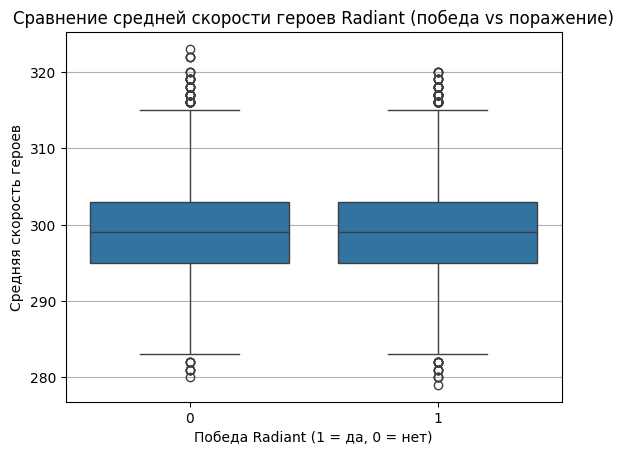

In [93]:
# Построим boxplot: победители vs проигравшие
sns.boxplot(x='rad_winner', y='radiant_avg_speed', data=df_cleaned)
plt.title("Сравнение средней скорости героев Radiant (победа vs поражение)")
plt.xlabel("Победа Radiant (1 = да, 0 = нет)")
plt.ylabel("Средняя скорость героев")
plt.grid(axis='y')
plt.show()

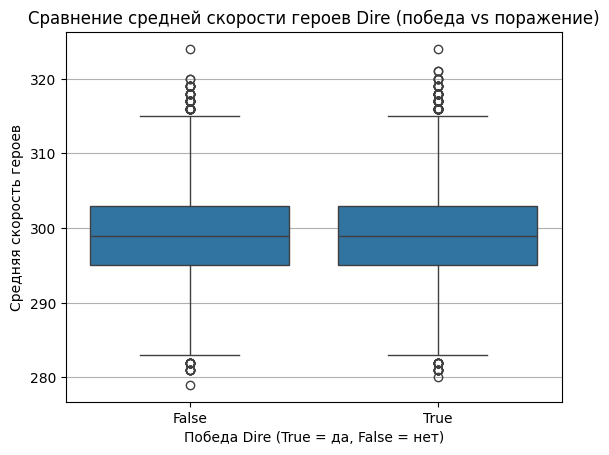

In [94]:
# Строим boxplot напрямую по условию победы Dire (rad_winner == 0)
sns.boxplot(x=(df_cleaned['rad_winner'] == 0), y='dire_avg_speed', data=df_cleaned)
plt.title("Сравнение средней скорости героев Dire (победа vs поражение)")
plt.xlabel("Победа Dire (True = да, False = нет)")
plt.ylabel("Средняя скорость героев")
plt.grid(axis='y')
plt.show()

Визуальный анализ показывает что средняя скорость героев практически одинакова в проигравших и выигравших командах

Давайте создадим новые признаки - Winrate команд используя исторические данные из датасета, но учитываем, что расчет берем по прошлым матчам чтобы избежать утечки данных

**ВАЖНО:**

 Для предотвращения утечки данных все агрегированные статистические признаки (winrate команд, игроков и героев) рассчитываются исключительно на основе матчей, сыгранных до текущего, с использованием временного сдвига shift(1).

 Для расчёта исторического винрейта использовалось сглаживание, основанное на байесовском априорном предположении о нейтральной вероятности победы (0.5). Это позволило снизить влияние малых выборок (из-за временного сдвига) и повысить устойчивость модели к шуму в данных, например если какая-то команда сыграла только один раз - это не допустит винрейт 0 или 1

In [95]:
alpha = 10  # Коэффициент сглаживания. Чем больше alpha, тем сильнее влияние "априорного" знания (0.5) и тем меньше влияние малых выборок.

def smoothed_wr(x, alpha=10):
    wins = x.shift(1).cumsum() # Количество побед до текущего матча
    games = x.shift(1).expanding().count() # Количество сыгранных матчей до текущего матча
    return (wins + alpha * 0.5) / (games + alpha) # Сглаженная оценка винрейта: добавляем alpha * 0.5 как априорное знание (нейтральный винрейт)

    """
    Функция расчёта сглаженного winrate.

    x — серия результатов матчей (1 = победа, 0 = поражение)
    Используется только информация ДО текущего матча (shift(1)),
    чтобы избежать утечки данных.
    """
    
# Radiant team winrate (Radiant wins = rad_winner)
df_cleaned['radiant_team_wr'] = (
    df_cleaned
    .groupby('radiant_team')['rad_winner']
    .transform(lambda x: smoothed_wr(x, alpha))
)

# Dire team winrate (Dire wins = 1 - rad_winner)
df_cleaned['dire_team_wr'] = (
    df_cleaned
    .groupby('dire_team')['rad_winner']
    .transform(lambda x: smoothed_wr(1 - x, alpha))
)

# Новые команды → нейтральный винрейт
df_cleaned[['radiant_team_wr', 'dire_team_wr']] = (df_cleaned[['radiant_team_wr', 'dire_team_wr']].fillna(0.5))

Также создадим признак общий winrate команды (независимо от стороны), но учитываем что расчет берем по прошлым матчам чтобы избежать утечки данных

In [96]:
# Radiant матчи
df_r = (
    df_cleaned[['date', 'radiant_team', 'rad_winner']]
    .rename(columns={'radiant_team': 'team', 'rad_winner': 'win'})
)

# Dire матчи
df_d = (
    df_cleaned[['date', 'dire_team', 'rad_winner']]
    .rename(columns={'dire_team': 'team', 'rad_winner': 'win'})
)
df_d['win'] = 1 - df_d['win']

# Объединяем
df_all = (
    pd.concat([df_r, df_d])
    .sort_values('date')
    .reset_index(drop=True)
)

# Сглаженный общий winrate
df_all['team_wr_all'] = (
    df_all
    .groupby('team')['win']
    .transform(lambda x: smoothed_wr(x, alpha))
)

df_all['team_wr_all'] = df_all['team_wr_all'].fillna(0.5)

df_cleaned = df_cleaned.merge(
    df_all[['date', 'team', 'team_wr_all']],
    left_on=['date', 'radiant_team'],
    right_on=['date', 'team'],
    how='left'
)

df_cleaned = df_cleaned.rename(
    columns={'team_wr_all': 'radiant_team_wr_all'}
).drop(columns=['team'])

df_cleaned = df_cleaned.merge(
    df_all[['date', 'team', 'team_wr_all']],
    left_on=['date', 'dire_team'],
    right_on=['date', 'team'],
    how='left'
)

df_cleaned = df_cleaned.rename(
    columns={'team_wr_all': 'dire_team_wr_all'}
).drop(columns=['team'])

# Новые команды → нейтральный винрейт
df_cleaned[['radiant_team_wr_all', 'dire_team_wr_all']] = (df_cleaned[['radiant_team_wr_all', 'dire_team_wr_all']].fillna(0.5))

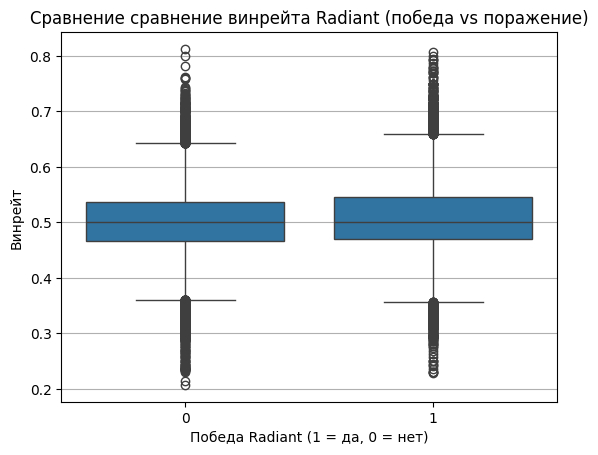

In [97]:
# Построим boxplot: победители vs проигравшие у Radiant
sns.boxplot(x='rad_winner', y='radiant_team_wr_all', data=df_cleaned)
plt.title("Сравнение сравнение винрейта Radiant (победа vs поражение)")
plt.xlabel("Победа Radiant (1 = да, 0 = нет)")
plt.ylabel("Винрейт")
plt.grid(axis='y')
plt.show()

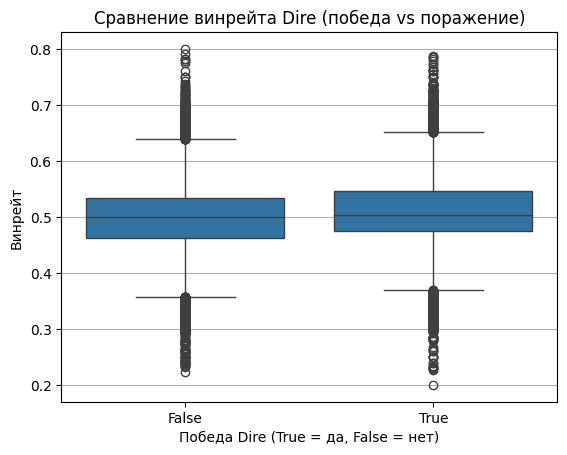

In [98]:
# Построим boxplot: победители vs проигравшие у Dire
sns.boxplot(x=(df_cleaned['rad_winner'] == 0), y='dire_team_wr_all', data=df_cleaned)
plt.title("Сравнение винрейта Dire (победа vs поражение)")
plt.xlabel("Победа Dire (True = да, False = нет)")
plt.ylabel("Винрейт")
plt.grid(axis='y')
plt.show()

Визуальный анализ показывает что винрейт команды (избегая утечку данных) незначительно, но влияет на вероятность победы

Проверим значимость этого наблюдения статистическим тестом. Для начала проверим данные на нормальность

In [99]:
# Разделяем данные на группы
radiant_winners = df_cleaned[df_cleaned['rad_winner'] == 1]['radiant_team_wr_all']
radiant_losers = df_cleaned[df_cleaned['rad_winner'] == 0]['radiant_team_wr_all']

dire_winners = df_cleaned[df_cleaned['rad_winner'] == 0]['dire_team_wr_all']
dire_losers = df_cleaned[df_cleaned['rad_winner'] == 1]['dire_team_wr_all']

# Проверка нормальности (тест Шапиро-Уилка)

print("\nRadiant (победители):")
stat, p = stats.shapiro(radiant_winners.sample(min(5000, len(radiant_winners))))
print(f"Shapiro-Wilk test: statistic={stat:.4f}, p-value={p:.6f}")

print("\nRadiant (проигравшие):")
stat, p = stats.shapiro(radiant_losers.sample(min(5000, len(radiant_losers))))
print(f"Shapiro-Wilk test: statistic={stat:.4f}, p-value={p:.6f}")

# Критерий: если p < 0.05, распределение не нормальное
# Для больших выборок (>5000) тест Шапиро слишком чувствителен


Radiant (победители):
Shapiro-Wilk test: statistic=0.9741, p-value=0.000000

Radiant (проигравшие):
Shapiro-Wilk test: statistic=0.9769, p-value=0.000000


Распределение не нормальное, воспользуемся тестом U-тест Манна-Уитни (непараметрический, если распределения не нормальные). Сформулируем нулевую и альтернативные гипотезы:

*Нулевая гипотеза*: Винрейт команды Radiant НЕ ВЫШЕ в матчах, которые они выиграли"

*Альтернативная гипотеза*: Винрейт команды Radiant СТАТИСТИЧЕСКИ ЗНАЧИМО ВЫШЕ в матчах, которые они выиграли

In [100]:
# Непараметрический тест, не требует нормальности
u_stat, p_value_u = stats.mannwhitneyu(
    radiant_winners,
    radiant_losers,
    alternative='greater'  # проверяем, что победители имеют большее значение
)

print(f"p-value: {p_value_u:.6f}")

if p_value_u < 0.05:
    print("✅ Статистически значимое различие")
else:
    print("❌ Нет статистически значимого различия")

p-value: 0.000000
✅ Статистически значимое различие


Тест показал, что винрейт команд имеет статистически значимое преимущество в играх Дота 2

Давайте создадим новые признаки - Winrate героев используя исторические данные из датасета, но учитываем что расчет берем по прошлым матчам чтобы избежать утечки данных - также используем временной сдвиг и сглаживание

In [101]:
def smoothed_wr(x, alpha=20, prior=0.5):
    wins = x.cumsum().shift(1)
    games = x.expanding().count().shift(1)
    return (wins + alpha * prior) / (games + alpha)

for i in range(1, 6):

    # ===== Radiant heroes =====
    rad_hero = f"radiant_hero_{i}_localized_name"
    rad_wr = f"radiant_hero_{i}_wr"

    df_cleaned[rad_wr] = (
        df_cleaned
        .groupby(rad_hero, dropna=False)['rad_winner']
        .transform(lambda x: smoothed_wr(x))
    )

    # ===== Dire heroes (инверсия результата) =====
    dire_hero = f"dire_hero_{i}_localized_name"
    dire_wr = f"dire_hero_{i}_wr"

    df_cleaned[dire_wr] = (
        df_cleaned
        .groupby(dire_hero, dropna=False)['rad_winner']
        .transform(lambda x: smoothed_wr(1 - x))
    )
    
hero_wr_cols = [
    c for c in df_cleaned.columns
    if c.startswith(('radiant_hero_', 'dire_hero_')) and c.endswith('_wr')
]

df_cleaned[hero_wr_cols] = df_cleaned[hero_wr_cols].fillna(0.5)

In [102]:
df_cleaned[hero_wr_cols].describe()

,radiant_hero_1_wr,dire_hero_1_wr,radiant_hero_2_wr,dire_hero_2_wr,radiant_hero_3_wr,dire_hero_3_wr,radiant_hero_4_wr,dire_hero_4_wr,radiant_hero_5_wr,dire_hero_5_wr
count,35546.000000,35546.000000,35546.000000,35546.000000,35546.000000,35546.000000,35546.000000,35546.000000,35546.000000,35546.000000
mean,0.516607,0.481880,0.517501,0.480708,0.516482,0.480368,0.516118,0.480824,0.514328,0.481911
std,0.044210,0.043712,0.044479,0.045253,0.045008,0.044838,0.045434,0.050101,0.051292,0.046589
min,0.352941,0.305556,0.338235,0.262295,0.330189,0.255319,0.304348,0.235294,0.307692,0.268817
25%,0.488095,0.454810,0.490000,0.452492,0.487013,0.452597,0.489552,0.451946,0.483333,0.456989
50%,0.517451,0.483516,0.516667,0.480874,0.514706,0.480620,0.514970,0.480519,0.513236,0.483871
75%,0.542105,0.506173,0.544643,0.510638,0.547619,0.509158,0.541872,0.512315,0.543860,0.510373
max,0.716216,0.666667,0.733333,0.682927,0.682927,0.728814,0.725000,0.725275,0.737705,0.651163


Давайте сравним средний винрейт героев у победителей и проигравших. Для этого создадим признаки radiant_avg_hero_wr и dire_avg_hero_wr

In [103]:
df_cleaned['radiant_avg_hero_wr'] = df_cleaned[[f"radiant_hero_{i}_wr" for i in range(1, 6)]].astype(float).mean(axis=1)
df_cleaned['dire_avg_hero_wr'] = df_cleaned[[f"dire_hero_{i}_wr" for i in range(1, 6)]].astype(float).mean(axis=1)

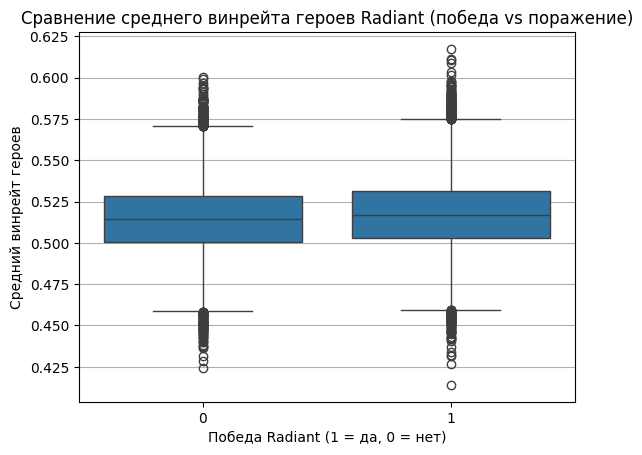

In [104]:
# Построим boxplot: победители vs проигравшие
sns.boxplot(x='rad_winner', y='radiant_avg_hero_wr', data=df_cleaned)
plt.title("Сравнение среднего винрейта героев Radiant (победа vs поражение)")
plt.xlabel("Победа Radiant (1 = да, 0 = нет)")
plt.ylabel("Средний винрейт героев")
plt.grid(axis='y')
plt.show()

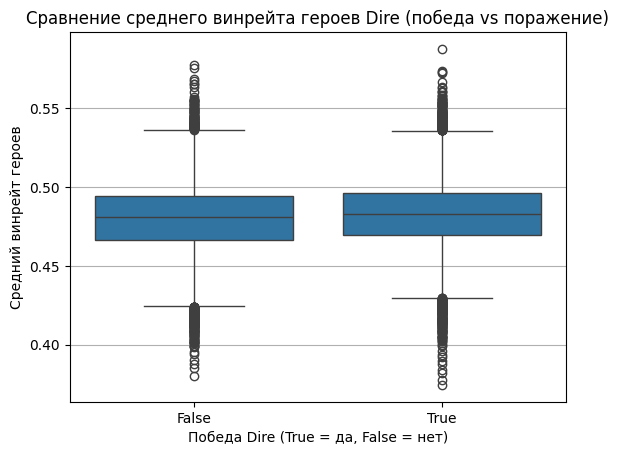

In [105]:
# Строим boxplot напрямую по условию победы Dire (rad_winner == 0)
sns.boxplot(x=(df_cleaned['rad_winner'] == 0), y='dire_avg_hero_wr', data=df_cleaned)
plt.title("Сравнение среднего винрейта героев Dire (победа vs поражение)")
plt.xlabel("Победа Dire (True = да, False = нет)")
plt.ylabel("Средний винрейт героев")
plt.grid(axis='y')
plt.show()

Визуальный анализ показывает что средний винрейт героев немного выше у выигравших команд

Давайте создадим новые признаки - Winrate игроков используя исторические данные из датасета, но учитываем что расчет берем по прошлым матчам чтобы избежать утечки данных - также используем временной сдвиг и сглаживание

In [106]:
def smoothed_wr(x, alpha=10, prior=0.5):
    wins = x.cumsum().shift(1)
    games = x.expanding().count().shift(1)
    return (wins + alpha * prior) / (games + alpha)

for i in range(1, 6):

    # ===== Radiant players =====
    rad_player = f"radiant_player_{i}_name"
    rad_player_wr = f"radiant_player_{i}_wr"

    df_cleaned[rad_player_wr] = (
        df_cleaned
        .groupby(rad_player, dropna=False)['rad_winner']
        .transform(lambda x: smoothed_wr(x))
    )

    # ===== Dire players (инверсия) =====
    dire_player = f"dire_player_{i}_name"
    dire_player_wr = f"dire_player_{i}_wr"

    df_cleaned[dire_player_wr] = (
        df_cleaned
        .groupby(dire_player, dropna=False)['rad_winner']
        .transform(lambda x: smoothed_wr(1 - x))
    )

player_wr_cols = [
    c for c in df_cleaned.columns
    if c.startswith(('radiant_player_', 'dire_player_')) and c.endswith('_wr')
]

df_cleaned[player_wr_cols] = df_cleaned[player_wr_cols].fillna(0.5)

Давайте сравним средний винрейт игроков у победителей и проигравших. Для этого создадим признаки radiant_avg_player_wr и dire_avg_player_wr

In [107]:
df_cleaned['radiant_avg_player_wr'] = df_cleaned[[f"radiant_player_{i}_wr" for i in range(1, 6)]].astype(float).mean(axis=1)
df_cleaned['dire_avg_player_wr'] = df_cleaned[[f"dire_player_{i}_wr" for i in range(1, 6)]].astype(float).mean(axis=1)

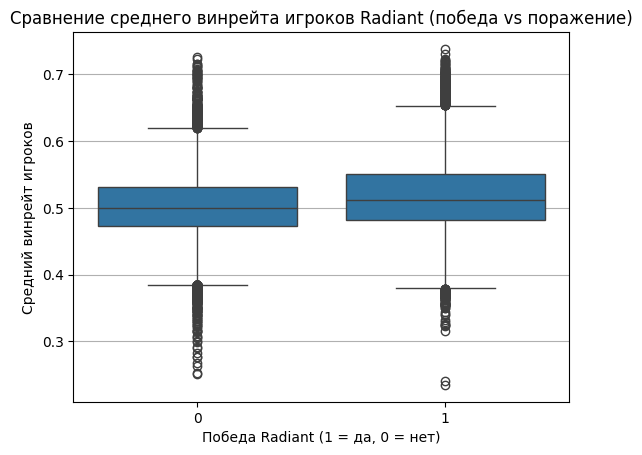

In [108]:
# Построим boxplot: победители vs проигравшие
sns.boxplot(x='rad_winner', y='radiant_avg_player_wr', data=df_cleaned)
plt.title("Сравнение среднего винрейта игроков Radiant (победа vs поражение)")
plt.xlabel("Победа Radiant (1 = да, 0 = нет)")
plt.ylabel("Средний винрейт игроков")
plt.grid(axis='y')
plt.show()

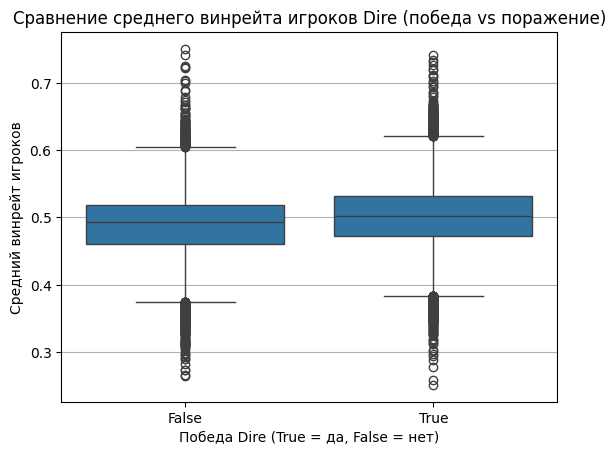

In [109]:
# Строим boxplot напрямую по условию победы Dire (rad_winner == 0)
sns.boxplot(x=(df_cleaned['rad_winner'] == 0), y='dire_avg_player_wr', data=df_cleaned)
plt.title("Сравнение среднего винрейта игроков Dire (победа vs поражение)")
plt.xlabel("Победа Dire (True = да, False = нет)")
plt.ylabel("Средний винрейт игроков")
plt.grid(axis='y')
plt.show()

Визуальный анализ показывает что средний винрейт игроков команды влияет на вероятность победы - средний винрейт игроков выше у выигравших команд

Создадим признаки синергии/антисинергии

In [110]:
# Ролевой баланс

RAD_ROLE_COLS = [f"radiant_hero_{i}_roles" for i in range(1, 6)]
DIRE_ROLE_COLS = [f"dire_hero_{i}_roles" for i in range(1, 6)]

def role_synergy(row, cols):
    roles = []
    for c in cols:
        if pd.notna(row[c]) and row[c] != "":
            roles.extend(row[c].split(", "))
    return len(set(roles))

df_cleaned['rad_role_diversity'] = df_cleaned.apply(
    lambda r: role_synergy(r, RAD_ROLE_COLS),
    axis=1
)

df_cleaned['dire_role_diversity'] = df_cleaned.apply(
    lambda r: role_synergy(r, DIRE_ROLE_COLS),
    axis=1
)

In [111]:
# Melee / Ranged баланс

df_cleaned['rad_melee_cnt'] = df_cleaned[[f"radiant_hero_{i}_attack_type" for i in range(1, 6)]].eq('Melee').sum(axis=1)
df_cleaned['dire_melee_cnt'] = df_cleaned[[f"dire_hero_{i}_attack_type" for i in range(1, 6)]].eq('Melee').sum(axis=1)
df_cleaned['rad_ranged_cnt'] = df_cleaned[[f"radiant_hero_{i}_attack_type" for i in range(1, 6)]].eq('Ranged').sum(axis=1)
df_cleaned['dire_ranged_cnt'] = df_cleaned[[f"dire_hero_{i}_attack_type" for i in range(1, 6)]].eq('Ranged').sum(axis=1)

In [112]:
# Move speed контраст

df_cleaned['move_speed_diff'] = df_cleaned['radiant_avg_speed'] - df_cleaned['dire_avg_speed']

In [113]:
# Winrate-синергия героев

df_cleaned['hero_wr_diff'] = df_cleaned['radiant_avg_hero_wr'] - df_cleaned['dire_avg_hero_wr']

In [114]:
# Winrate-синергия игроков

df_cleaned['player_wr_diff'] = df_cleaned['radiant_avg_player_wr'] - df_cleaned['dire_avg_player_wr']

In [115]:
# Winrate-синергия команды

df_cleaned['team_wr_all_diff'] = (df_cleaned['radiant_team_wr_all'] - df_cleaned['dire_team_wr_all'])

Подготовим датасет для модели, сперва отдельно скопируем датасет

In [116]:
df_model = df_cleaned.copy()

Удалим неинформативные признаки и имена героев и игроков, так как мы уже получили от этих признаков необходимые новые признаки

In [117]:
# признаки для удаления
cols_to_drop = ['date', 'tournament', 'game_patch']

# имена игроков и героев
for i in range(1, 6):
    cols_to_drop += [
        f'radiant_player_{i}_name',
        f'dire_player_{i}_name',
        f'radiant_hero_{i}_localized_name',
        f'dire_hero_{i}_localized_name'
    ]
    
df_model = df_model.drop(columns=cols_to_drop, errors='ignore')

Сгруппируем признаки для удобства

In [118]:
TARGET = 'rad_winner'

# Категориальные признаки
team_cols = ['radiant_team','dire_team']
role_cols = [c for c in df_model.columns if c.endswith('_roles')]
primary_attr_cols = [c for c in df_model.columns if c.endswith('_primary_attr')]
attack_type_cols = [c for c in df_model.columns if c.endswith('_attack_type')]

# Числовые признаки
numeric_cols = [
    c for c in df_model.columns
    if c not in team_cols + role_cols + primary_attr_cols + attack_type_cols + [TARGET]
]

Выведем сильно скоррелированные числовые признаки

In [119]:
corr_matrix = df_model[numeric_cols].corr()
threshold = 0.70
high_correlation = []
for feature in corr_matrix:
    correlated_features = corr_matrix[feature][(abs(corr_matrix[feature]) > threshold) & (abs(corr_matrix[feature]) < 1)]
    for correlated_feature, correlation_value in correlated_features.items():
        high_correlation.append((feature, correlated_feature, correlation_value))
high_corr_matrix = pd.DataFrame(high_correlation, columns=['Feature 1', 'Feature 2', 'Correlation'])
high_corr_matrix

,Feature 1,Feature 2,Correlation
0,radiant_avg_speed,move_speed_diff,0.722910
1,dire_avg_speed,move_speed_diff,-0.726389
2,radiant_avg_hero_wr,hero_wr_diff,0.745473
3,dire_avg_hero_wr,hero_wr_diff,-0.744382
4,radiant_player_1_wr,radiant_avg_player_wr,0.709048
5,dire_player_1_wr,dire_avg_player_wr,0.704586
6,radiant_player_2_wr,radiant_avg_player_wr,0.706149
7,radiant_player_5_wr,radiant_avg_player_wr,0.700020
8,radiant_avg_player_wr,radiant_player_1_wr,0.709048
9,radiant_avg_player_wr,radiant_player_2_wr,0.706149


Удаление признаков с коэффициентом корреляции +-0.70 дало результат чуть хуже, поэтому оставим данные признаки

In [120]:
# cols_to_drop = ['radiant_avg_speed',
#                'dire_avg_speed',
#                'radiant_avg_hero_wr', 
#                'dire_avg_hero_wr', 
#                'radiant_avg_player_wr',
#                'dire_avg_player_wr',
# ]
# df_model = df_model.drop(columns=cols_to_drop, errors='ignore')

Кодирование ролей героев

In [121]:
def split_roles(series):
    return series.fillna("").apply(lambda x: x.split(',') if x else [])

mlb = MultiLabelBinarizer()

role_features = []
for col in role_cols:
    roles_encoded = mlb.fit_transform(split_roles(df_model[col]))
    role_df = pd.DataFrame(
        roles_encoded,
        columns=[f"{col}_{r}" for r in mlb.classes_],
        index=df_model.index
    )
    role_features.append(role_df)

roles_encoded_df = pd.concat(role_features, axis=1)

One-Hot кодирование для остальных категорий (названия команд, атрибуты и типы атак)

In [122]:
from sklearn.preprocessing import OneHotEncoder

team_encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=True)
attr_encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=True)
attack_encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=True)

team_encoded_df = team_encoder.fit_transform(df_model[team_cols])
attr_encoded_df = attr_encoder.fit_transform(df_model[primary_attr_cols])
attack_type_encoded_df = attack_encoder.fit_transform(df_model[attack_type_cols])

Собираем финальный датасет для обучения моделей

In [123]:
X = hstack([
    df_model[numeric_cols],
    team_encoded_df,
    attr_encoded_df,
    attack_type_encoded_df,
    roles_encoded_df
])

y = df_model[TARGET]

## Построение моделей прогнозирования

### Подготовка данных для модели

Как уже отмечалось выше - мы вышли на простейший алгоритм угадывания - Baseline, выбирая всегда команду Radiant вы будете иметь небольшое преимущество. Таким образом нам необходимо сделать модель с точностью не менее 51.8%. Попробуем это сделать с помощью методов ML

Делим на тестовую и тренировочную выборку

In [125]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    shuffle=True,
    random_state=42
)

Скалирование не используем - оно дало результат с меньшей точностью

In [126]:
#from sklearn.preprocessing import MaxAbsScaler

#scaler = MaxAbsScaler()
#scaler.fit(X_train)
#X_train_scaled = scaler.transform(X_train)
#X_test_scaled = scaler.transform(X_test)

### Модель Логистическая регрессия

Для начала построим простую модель - логистическая регрессия

In [127]:
#Создаем объект класса логистическая регрессия
log_reg = linear_model.LogisticRegression(
    solver='sag', #алгоритм оптимизации
    random_state=42, #генератор случайных чисел
    max_iter=1000 #количество итераций на сходимость
)
#Обучаем модель, минимизируя logloss
log_reg.fit(X_train, y_train)

c:\Users\Олег\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,42
,solver,'sag'
,max_iter,1000
,multi_class,'deprecated'


In [128]:
#Делаем предсказание для тренировочной выборки
y_train_pred = log_reg.predict(X_train)
#Вывод отчет о метриках классификации
print(metrics.classification_report(y_train, y_train_pred))
#Делаем предсказание для тестовой выборки
y_test_pred = log_reg.predict(X_test)
#Вывод отчет о метриках классификации
print(metrics.classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.56      0.41      0.47     13704
           1       0.56      0.70      0.62     14732

    accuracy                           0.56     28436
   macro avg       0.56      0.55      0.55     28436
weighted avg       0.56      0.56      0.55     28436

              precision    recall  f1-score   support

           0       0.53      0.40      0.45      3427
           1       0.55      0.68      0.60      3683

    accuracy                           0.54      7110
   macro avg       0.54      0.54      0.53      7110
weighted avg       0.54      0.54      0.53      7110



В качестве базовой модели была использована логистическая регрессия для предсказания исхода матча Dota 2. Оценка качества проводилась на обучающей и тестовой выборках с использованием метрик precision, recall, F1-score и accuracy.

На обучающей выборке модель показала:

- Accuracy: 0.56

- Macro F1-score: 0.55

На тестовой выборке результаты составили:

- Accuracy: 0.54

- Macro F1-score: 0.53

Это говорит о том, что модель обобщается стабильно: разница между train и test невелика, признаков переобучения не наблюдается. Но результат довольно невысокий

Найдём наилучшие значения гиперпараметров методом GridSearchCV для логистической регрессии 

In [129]:
param_grid = [
              {'penalty': ['l2', 'None'] , # тип регуляризации
              'solver': ['lbfgs', 'sag'], # алгоритм оптимизации
               'C': [0.01, 0.1, 0.3, 0.5, 0.7, 0.9, 1]}, # уровень силы регурялизации
              
              {'penalty': ['l1', 'l2'] ,
              'solver': ['liblinear', 'saga'],
               'C': [0.01, 0.1, 0.3, 0.5, 0.7, 0.9, 1]}
]
grid_search = GridSearchCV(
    estimator=linear_model.LogisticRegression(random_state=42, max_iter=50), 
    param_grid=param_grid, 
    cv=5, #количество фолдов в кросс-валидации
    n_jobs = -1, #количество ядер для распараллеливания расчёта. -1 использует все существующие ядра
    scoring='f1'  # Используем F1-метрику
)  
%time grid_search.fit(X_train, y_train)
y_train_pred = grid_search.predict(X_train)
print('f1_score на обучающем наборе: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))
y_test_pred = grid_search.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))
print("Наилучшие значения гиперпараметров: {}".format(grid_search.best_params_))

c:\Users\Олег\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\model_selection\_validation.py:516: FitFailedWarning: 
70 fits failed out of a total of 280.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
28 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Олег\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\model_selection\_validation.py", line 859, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
    ~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Олег\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\base.py", line 1356, in wrapper
    estimator._validate_params()
    ~~~~~~~~~~~~~~~~~~~~~~~~~~^^
  File "c:\User

CPU times: total: 7.52 s
Wall time: 10min 7s
f1_score на обучающем наборе: 0.66
f1_score на тестовом наборе: 0.66
Наилучшие значения гиперпараметров: {'C': 0.01, 'penalty': 'l1', 'solver': 'saga'}


c:\Users\Олег\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Выведем наилучшую модель с гиперпараметрами расчитанными по методу GridSeachCV и метрики

In [130]:
best_model_LogReg = grid_search.best_estimator_

best_model_LogReg.fit(X_train, y_train)

y_pred = best_model_LogReg.predict(X_test)

print("Наилучшая модель:", grid_search.best_estimator_)
print("\nTest F1-score:", f1_score(y_test, y_pred))
print("\nClassification report:")
print(classification_report(y_test, y_pred))

Наилучшая модель: LogisticRegression(C=0.01, max_iter=50, penalty='l1', random_state=42,
                   solver='saga')

Test F1-score: 0.6560708178251685

Classification report:
              precision    recall  f1-score   support

           0       0.50      0.13      0.20      3427
           1       0.52      0.89      0.66      3683

    accuracy                           0.52      7110
   macro avg       0.51      0.51      0.43      7110
weighted avg       0.51      0.52      0.44      7110



c:\Users\Олег\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


В результате подбора гиперпараметров была получена оптимальная модель LogisticRegression с L1-регуляризацией и параметрами: коэффициент регуляризации 
𝐶=0.01, максимальное число итераций — 50, решатель saga. Использование L1-регуляризации позволило выполнить неявный отбор признаков и снизить риск переобучения модели.

Оценка качества модели проводилась на тестовой выборке с использованием метрики F1-score, что является целесообразным для бинарной классификации с нестрогим балансом классов.

На тестовой выборке модель достигла значения F1-score = 0.656, что является наилучшим результатом среди рассмотренных базовых моделей и свидетельствует о высокой способности модели выявлять закономерности в данных.

Анализ отчёта классификации показывает выраженную асимметрию в качестве предсказаний по классам:

- для класса rad_winner = 1 (победа команды Radiant) модель демонстрирует высокую полноту (recall = 0.89) и F1-score = 0.66, что указывает на способность модели эффективно выявлять победы Radiant;

- для класса rad_winner = 0 (победа команды Dire) значение F1-score = 0.20, при крайне низкой полноте (recall = 0.13), что означает, что модель часто ошибочно классифицирует победы Dire как победы Radiant.

Общая точность модели составила 52%, что лишь незначительно превышает уровень случайного угадывания. Однако высокая величина F1-score для целевого класса Radiant объясняется сильным смещением модели в сторону предсказания данного класса.

### Модель Случайный лес

Построим модель случайный лес и найдём наилучшие значения гиперпараметров методом GridSearchCV

In [131]:
# Задаем сетку гиперпараметров для поиска:
param_grid = {'n_estimators': list(range(80, 200, 30)), 
              'min_samples_leaf': [5],
              'max_depth': list(np.linspace(20, 40, 5, dtype=int))
              }
# Создаем объект GridSearchCV для подбора гиперпараметров:            
grid_search_forest = GridSearchCV(
    estimator=ensemble.RandomForestClassifier(random_state=42), 
    param_grid=param_grid, 
    cv=5, #количество фолдов в кросс-валидации (5)
    n_jobs = -1, #используем все доступные процессоры для параллельных вычислений
    scoring='f1'  # Используем F1-метрику
)
# Обучаем модель с подбором гиперпараметров  
%time grid_search_forest.fit(X_train, y_train)
y_train_pred = grid_search_forest.predict(X_train)
print('f1_score на обучающем наборе: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))
y_test_pred = grid_search_forest.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))
print("Наилучшие значения гиперпараметров: {}".format(grid_search_forest.best_params_))

CPU times: total: 43.8 s
Wall time: 5min 57s
f1_score на обучающем наборе: 0.97
f1_score на тестовом наборе: 0.62
Наилучшие значения гиперпараметров: {'max_depth': np.int64(30), 'min_samples_leaf': 5, 'n_estimators': 170}


Выведем наилучшую модель с гиперпараметрами расчитанными по методу GridSeachCV и метрики

In [132]:
best_model_RanFor = grid_search_forest.best_estimator_

best_model_RanFor.fit(X_train, y_train)

y_pred = best_model_RanFor.predict(X_test)

print("Наилучшая модель:", grid_search_forest.best_estimator_)
print("\nTest F1-score:", f1_score(y_test, y_pred))
print("\nClassification report:")
print(classification_report(y_test, y_pred))

Наилучшая модель: RandomForestClassifier(max_depth=np.int64(30), min_samples_leaf=5,
                       n_estimators=170, random_state=42)

Test F1-score: 0.6202385532897268

Classification report:
              precision    recall  f1-score   support

           0       0.58      0.51      0.54      3427
           1       0.59      0.66      0.62      3683

    accuracy                           0.58      7110
   macro avg       0.58      0.58      0.58      7110
weighted avg       0.58      0.58      0.58      7110



В результате подбора гиперпараметров была получена оптимальная модель RandomForestClassifier со следующими параметрами: максимальная глубина деревьев — 30, минимальное количество объектов в листе — 5, количество деревьев — 170.

Качество модели оценивалось на отложенной тестовой выборке с использованием метрики F1-score, поскольку задача представляет собой бинарную классификацию с близким, но не строго сбалансированным распределением классов.

На тестовой выборке модель достигла значения F1-score = 0.62, что указывает на хорошее качество классификации и сбалансированное соотношение точности и полноты предсказаний.

Анализ отчёта классификации показывает, что:

- для класса rad_winner = 1 (победа команды Radiant) модель демонстрирует F1-score = 0.62 и recall = 0.66, что говорит о способности модели достаточно хорошо выявлять победы команды Radiant;

- для класса rad_winner = 0 (победа команды Dire) значение F1-score = 0.54, при этом полнота ниже, чем для класса Radiant, что указывает на большую сложность прогнозирования побед команды Dire.

Общая точность классификации составила 58%, что превышает базовый уровень случайного угадывания и подтверждает наличие полезного сигнала в используемых признаках.

### Модель LGBM

Строим модель LGBM классификатор и подбираем лучшие гиперпараметры

In [133]:
# Базовая модель
lgbm = LGBMClassifier(
    objective='binary', #бинарная классификация
    boosting_type='gbdt', #градиентный бустинг на деревьях решений
    random_state=42,
    n_jobs=-1
)

# Сетка гиперпараметров
param_grid = {
    'n_estimators': [200, 300, 400],
    'learning_rate': [0.03, 0.05, 0.07],
    'num_leaves': [31, 63],
    'max_depth': [-1, 10],
    'min_child_samples': [20, 40]
}

# F1 как целевая метрика
f1_scorer = make_scorer(f1_score)

grid = GridSearchCV(
    estimator=lgbm,
    param_grid=param_grid,
    scoring=f1_scorer,
    cv=5,
    verbose=2,
    n_jobs=-1
)

# Запуск подбора
grid.fit(X_train, y_train)

# Лучшие параметры
print("Best parameters:")
print(grid.best_params_)

print(f"Best CV F1-score: {grid.best_score_:.4f}")

Fitting 5 folds for each of 72 candidates, totalling 360 fits
[LightGBM] [Info] Number of positive: 14732, number of negative: 13704
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018484 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9340
[LightGBM] [Info] Number of data points in the train set: 28436, number of used features: 589
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.518076 -> initscore=0.072334
[LightGBM] [Info] Start training from score 0.072334
Best parameters:
{'learning_rate': 0.03, 'max_depth': -1, 'min_child_samples': 20, 'n_estimators': 200, 'num_leaves': 31}
Best CV F1-score: 0.6191


Выведем наилучшую модель с гиперпараметрами расчитанными по методу GridSeachCV и метрики

In [134]:
best_model_lgbm = grid.best_estimator_

best_model_lgbm.fit(X_train, y_train)

y_pred = best_model_lgbm.predict(X_test)

print("Наилучшая модель:", grid.best_estimator_)
print("📊 Test F1-score:", f1_score(y_test, y_pred))
print("\nClassification report:")
print(classification_report(y_test, y_pred))

[LightGBM] [Info] Number of positive: 14732, number of negative: 13704
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007466 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9340
[LightGBM] [Info] Number of data points in the train set: 28436, number of used features: 589
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.518076 -> initscore=0.072334
[LightGBM] [Info] Start training from score 0.072334
Наилучшая модель: LGBMClassifier(learning_rate=0.03, n_estimators=200, n_jobs=-1,
               objective='binary', random_state=42)
📊 Test F1-score: 0.6271767810026385

Classification report:
              precision    recall  f1-score   support

           0       0.59      0.56      0.57      3427
           1       0.61      0.65      0.63      3683

    accuracy                           0.60      7110
   macro avg       0.60      0.

c:\Users\Олег\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


По результатам обучения и тестирования модели на отложенной выборке было достигнуто значение F1-score = 0.627, что свидетельствует о стабильном и сбалансированном качестве классификации по сравнению с базовыми моделями.

Анализ отчёта классификации показывает, что модель демонстрирует сопоставимое качество предсказаний для обоих классов. Для класса rad_winner = 1 (победа команды Radiant) получены значения precision = 0.63, recall = 0.65 и F1-score = 0.63, что указывает на хорошую способность модели выявлять победы Radiant без существенного роста ложноположительных срабатываний. Для класса rad_winner = 0 (победа команды Dire) значения метрик также находятся на сопоставимом уровне (F1-score = 0.57), что свидетельствует об отсутствии сильного смещения модели в сторону одного из классов.

Общая точность модели составила 60%, а значения macro avg и weighted avg F1-score совпадают и равны 0.60, что подтверждает равномерное качество классификации независимо от размера классов. В отличие от модели логистической регрессии с L1-регуляризацией, данная модель обеспечивает более сбалансированное распределение ошибок между классами.

В целом, полученные результаты позволяют сделать вывод, что модель обеспечивает устойчивое и интерпретируемое качество предсказаний, избегая выраженного перекоса в сторону одного из исходов матча. Это делает её более надёжной с практической точки зрения, особенно в задачах прогнозирования, где важно корректно учитывать оба возможных результата.

### Сравнение и выбор финальной модели

Построим таблицу сравнения метрик по классам 1 и 0:

| Модель                  | Accuracy | Precision (1) | Recall (1) | F1-score (1) | Macro F1 |
|-------------------------|----------|---------------|------------|--------------|----------|
| Logistic Regression     | 0.52     | 0.52          | 0.89       | 0.66         | 0.43     |
| Random Forest           | 0.58     | 0.59          | 0.66       | 0.62         | 0.58     |
| LightGBM                | **0.60** | **0.61**      | 0.65       | 0.63         | **0.60** |


| Модель              | Precision (0) | Recall (0) | F1-score (0) |
|---------------------|---------------|------------|--------------|
| Logistic Regression | 0.50          | 0.13       | 0.20         |
| Random Forest       | 0.58          | 0.51       | 0.54         |
| LightGBM            | **0.59**      | **0.56**   | **0.57**     |


Анализ качества моделей по обоим классам показывает существенные различия в их поведении.

- Логистическая регрессия демонстрирует крайне слабое качество предсказания класса 0: F1-score составляет всего 0.20, а recall — 0.13. Это означает, что модель почти не распознаёт победы Dire и систематически смещена в сторону предсказания победы Radiant. Несмотря на высокий F1-score для класса 1, такое поведение делает модель непригодной для практического использования в задаче прогнозирования исходов матчей, где важна адекватная обработка обоих исходов.

- RandomForestClassifier значительно улучшает качество классификации класса 0, достигая F1-score = 0.54. Модель демонстрирует сбалансированное соотношение precision и recall, что указывает на устойчивое распознавание как побед Radiant, так и побед Dire. Это делает модель более надёжной по сравнению с логистической регрессией.

- LightGBM показывает наилучшее качество для класса 0 с F1-score = 0.57 и наибольшим recall (0.56). В сочетании с высокими и сбалансированными метриками для класса 1 и наивысшим Macro F1, данная модель обеспечивает наиболее равномерное качество классификации по обоим классам.

📌 Итоговый вывод

Нашим приоритетом является симметричное качество предсказаний для обоих исходов матча, наилучшим выбором является LightGBM.

### Анализ важности признаков

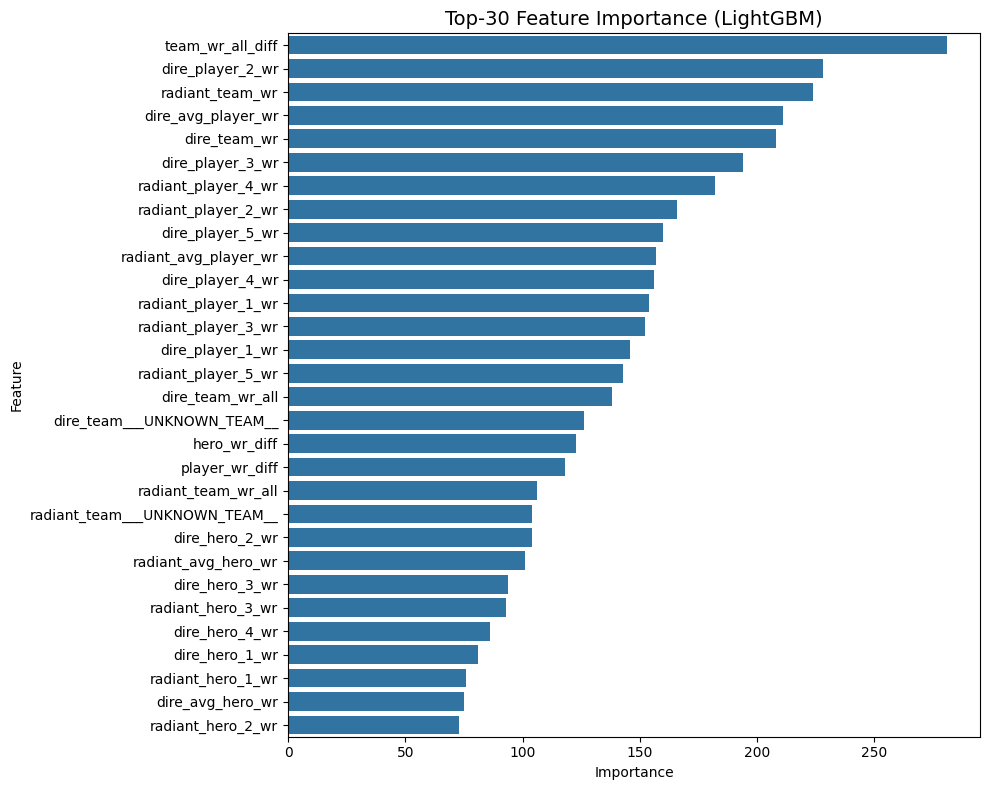

In [135]:
#Имена числовых признаков
numeric_feature_names = list(numeric_cols)

#Имена OneHot-признаков
team_feature_names = team_encoder.get_feature_names_out(team_cols)
attr_feature_names = attr_encoder.get_feature_names_out(primary_attr_cols)
attack_feature_names = attack_encoder.get_feature_names_out(attack_type_cols)

#Имена MultiLabel-признаков
role_feature_names = roles_encoded_df.columns.tolist()

#Финальный список признаков В ТОМ ЖЕ ПОРЯДКЕ, ЧТО hstack
all_feature_names = (
    numeric_feature_names
    + list(team_feature_names)
    + list(attr_feature_names)
    + list(attack_feature_names)
    + list(role_feature_names)
)

#DataFrame важности признаков
feature_importance = pd.DataFrame({
    'feature': all_feature_names,
    'importance': best_model_lgbm.feature_importances_
}).sort_values(by='importance', ascending=False)

#Визуализация топ Топ-30 признаков
top_features = feature_importance.head(30)
plt.figure(figsize=(10, 8))
sns.barplot(
    data=top_features,
    x='importance',
    y='feature'
)

plt.title('Top-30 Feature Importance (LightGBM)', fontsize=14)
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

Анализ важности признаков модели LightGBM показал, что ключевую роль в прогнозировании исхода матча играют агрегированные показатели винрейта команд, игроков и героев. Наибольший вклад в модель вносит разница командного винрейта (team_wr_all_diff), а также индивидуальные винрейты игроков и команды Radiant. Это указывает на то, что модель в первую очередь опирается на историческую силу команд и игроков, а не на случайные или единичные характеристики. Таким образом, используемые признаки адекватно отражают реальную структуру данных и логически согласуются с игровой механикой Dota 2.

### Вывод о целесообразности модели

Вычислим AUC-ROC метрику финальной модели

AUC-ROC: 0.6596


c:\Users\Олег\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


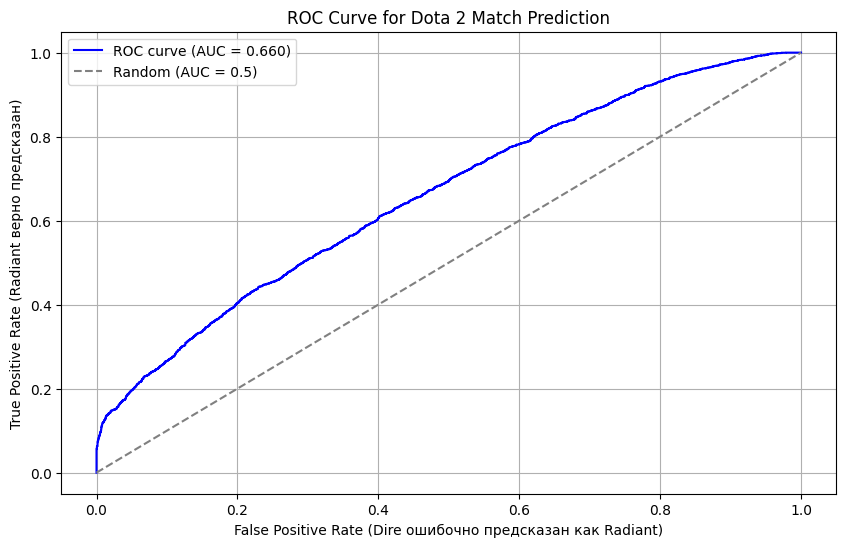

In [136]:
# Получаем вероятности для тестовой выборки
y_pred_proba = best_model_lgbm.predict_proba(X_test)[:, 1]  # Вероятности класса 1 (Radiant)

# Вычисляем AUC-ROC
auc_roc = roc_auc_score(y_test, y_pred_proba)
print(f"AUC-ROC: {auc_roc:.4f}")

# Строим ROC-кривую
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {auc_roc:.3f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', label='Random (AUC = 0.5)')
plt.xlabel('False Positive Rate (Dire ошибочно предсказан как Radiant)')
plt.ylabel('True Positive Rate (Radiant верно предсказан)')
plt.title('ROC Curve for Dota 2 Match Prediction')
plt.legend()
plt.grid(True)
plt.show()

Построенная ROC-кривая демонстрирует способность модели различать победу команд Radiant и Dire при различных значениях порога классификации. Площадь под ROC-кривой (AUC) составила 0.66, что существенно превышает значение случайного классификатора (AUC = 0.5).

Это означает, что модель в среднем в 66% случаев присваивает более высокую вероятность победы действительно выигравшей команде, чем проигравшей. Таким образом, классификатор обладает умеренной, но стабильной дискриминирующей способностью.

Форма ROC-кривой показывает, что при увеличении True Positive Rate (доли правильно предсказанных побед Radiant) наблюдается контролируемый рост False Positive Rate, что свидетельствует о разумном компромиссе между чувствительностью и специфичностью модели. Это особенно важно в задаче прогнозирования исходов матчей, где данные характеризуются высокой вариативностью и влиянием случайных факторов.

В целом, значение AUC подтверждает, что модель извлекает информативные паттерны из признаков и способна принимать решения лучше случайного угадывания, что делает её пригодной для практического использования в рамках поставленной задачи.

## Создание пайплайна

Кастомный трансформер DotaFeatureGenerator:
- принимает сырые данные
- добавляет новые колонки
- возвращает DataFrame

In [146]:
class DotaFeatureGenerator(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()

        # Avg move speed
        X['radiant_avg_speed'] = X[[f"radiant_hero_{i}_move_speed" for i in range(1, 6)]].mean(axis=1)
        X['dire_avg_speed'] = X[[f"dire_hero_{i}_move_speed" for i in range(1, 6)]].mean(axis=1)

        # Role diversity
        RAD_ROLE_COLS = [f"radiant_hero_{i}_roles" for i in range(1, 6)]
        DIRE_ROLE_COLS = [f"dire_hero_{i}_roles" for i in range(1, 6)]

        def role_synergy(row, cols):
            roles = []
            for c in cols:
                if pd.notna(row[c]) and row[c] != "":
                    roles.extend(row[c].split(", "))
            return len(set(roles))

        X['rad_role_diversity'] = X.apply(lambda r: role_synergy(r, RAD_ROLE_COLS), axis=1)
        X['dire_role_diversity'] = X.apply(lambda r: role_synergy(r, DIRE_ROLE_COLS), axis=1)

        # Melee / Ranged
        X['rad_melee_cnt'] = X[[f"radiant_hero_{i}_attack_type" for i in range(1, 6)]].eq('Melee').sum(axis=1)
        X['dire_melee_cnt'] = X[[f"dire_hero_{i}_attack_type" for i in range(1, 6)]].eq('Melee').sum(axis=1)
        X['rad_ranged_cnt'] = X[[f"radiant_hero_{i}_attack_type" for i in range(1, 6)]].eq('Ranged').sum(axis=1)
        X['dire_ranged_cnt'] = X[[f"dire_hero_{i}_attack_type" for i in range(1, 6)]].eq('Ranged').sum(axis=1)

        # Avg player WR
        X['radiant_avg_player_wr'] = X[[f"radiant_player_{i}_wr" for i in range(1, 6)]].astype(float).mean(axis=1)
        X['dire_avg_player_wr'] = X[[f"dire_player_{i}_wr" for i in range(1, 6)]].astype(float).mean(axis=1)

        # Avg hero WR
        X['radiant_avg_hero_wr'] = X[[f"radiant_hero_{i}_wr" for i in range(1, 6)]].astype(float).mean(axis=1)
        X['dire_avg_hero_wr'] = X[[f"dire_hero_{i}_wr" for i in range(1, 6)]].astype(float).mean(axis=1)

        # Diffs
        X['move_speed_diff'] = X['radiant_avg_speed'] - X['dire_avg_speed']
        X['hero_wr_diff'] = X['radiant_avg_hero_wr'] - X['dire_avg_hero_wr']
        X['player_wr_diff'] = X['radiant_avg_player_wr'] - X['dire_avg_player_wr']
        X['team_wr_all_diff'] = X['radiant_team_wr_all'] - X['dire_team_wr_all']

        return X

Группируем признаки

In [147]:
numeric_cols = [
    'radiant_avg_speed', 'dire_avg_speed', 'move_speed_diff',
    'rad_melee_cnt', 'dire_melee_cnt',
    'rad_ranged_cnt', 'dire_ranged_cnt',

    # target-aware признаки (уже посчитаны ДО pipeline)
    'radiant_team_wr', 'dire_team_wr',
    'radiant_team_wr_all', 'dire_team_wr_all',
    'team_wr_all_diff',
    'radiant_avg_hero_wr', 'dire_avg_hero_wr', 'hero_wr_diff',
    'radiant_avg_player_wr', 'dire_avg_player_wr', 'player_wr_diff',
]

# Категориальные признаки
team_cols = ['radiant_team','dire_team']
role_cols = [c for c in df_model.columns if c.endswith('_roles')]
primary_attr_cols = [c for c in df_model.columns if c.endswith('_primary_attr')]
attack_type_cols = [c for c in df_model.columns if c.endswith('_attack_type')]

Кастомный трансформер RoleBinarizer:
- получает только role_cols
- превращает “Carry,Support” → бинарные признаки

In [148]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.utils.validation import check_is_fitted
import numpy as np
import pandas as pd

class RolesMLBEncoder(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.binarizers = {}  # Словарь для хранения разных бинаризаторов для каждой колонки
        self.feature_names_out_ = None
        
    def split_roles(self, series):
        """Разделяет строку ролей на список"""
        
        return series.fillna("").apply(lambda x: x.split(',') if x else [])
    
    def fit(self, X, y=None):
        """Обучает отдельный MultiLabelBinarizer для каждой колонки"""
        
        self.binarizers = {}
        self.column_names_ = list(X.columns)  # Сохраняем порядок колонок
        
        all_feature_names = []
        
        for col in X.columns:
            # Создаем и обучаем отдельный бинаризатор для каждой колонки
            binarizer = MultiLabelBinarizer()
            roles_split = self.split_roles(X[col])
            binarizer.fit(roles_split)
            self.binarizers[col] = binarizer
            
            # Сохраняем имена признаков для этой колонки
            for role_name in binarizer.classes_:
                all_feature_names.append(f"{col}_{role_name}")
        
        self.feature_names_out_ = np.array(all_feature_names)
        return self
    
    def transform(self, X):
        """Преобразует роли в бинарные признаки"""

        check_is_fitted(self, ['binarizers', 'column_names_'])
        
        # Проверяем, что колонки совпадают с теми, на которых обучали
        if set(X.columns) != set(self.column_names_):
            raise ValueError(
                f"Колонки в transform отличаются от fit. "
                f"Обучались на: {self.column_names_}, "
                f"получили: {list(X.columns)}"
            )
        
        all_encoded = []
        
        # Преобразуем каждую колонку в том же порядке, что и при обучении
        for col in self.column_names_:
            binarizer = self.binarizers[col]
            roles_split = self.split_roles(X[col])
            encoded = binarizer.transform(roles_split)
            all_encoded.append(encoded)
        
        # Объединяем все признаки
        return np.hstack(all_encoded)
    
    def get_feature_names_out(self, input_features=None):
        """Возвращает имена признаков после преобразования"""

        check_is_fitted(self, 'feature_names_out_')
        return self.feature_names_out_

ColumnTransformer — следующий шаг pipeline

In [149]:
preprocessor = ColumnTransformer(
    transformers=[
        ("num", "passthrough", numeric_cols),

        ("teams", OneHotEncoder(
            handle_unknown="ignore",
            sparse_output=False
        ), team_cols),

        ("attr", OneHotEncoder(
            handle_unknown="ignore",
            sparse_output=False
        ), primary_attr_cols),

        ("attack", OneHotEncoder(
            handle_unknown="ignore",
            sparse_output=False
        ), attack_type_cols),

        ("roles", RolesMLBEncoder(), role_cols),
    ],
    remainder="drop",
    verbose_feature_names_out=False
)

Финальный Pipeline с наилучшими расчитанными гиперпараметрами

In [156]:
print("Наилучшая модель:", grid.best_estimator_)
print(grid.best_params_)

Наилучшая модель: LGBMClassifier(learning_rate=0.03, n_estimators=200, n_jobs=-1,
               objective='binary', random_state=42)
{'learning_rate': 0.03, 'max_depth': -1, 'min_child_samples': 20, 'n_estimators': 200, 'num_leaves': 31}


In [157]:
pipeline = Pipeline(
    steps=[
        ('feature_gen', DotaFeatureGenerator()),
        ('preprocess', preprocessor),
        ('model', LGBMClassifier(
            objective='binary',
            boosting_type='gbdt',
            n_estimators=200,
            learning_rate=0.03,
            num_leaves=31,
            max_depth=-1,
            min_child_samples=20,
            random_state=42,
            n_jobs=-1,
        ))
    ]
)

Обучение

In [158]:
TARGET = 'rad_winner'

X = df_model.drop(columns=[TARGET])
y = df_model[TARGET]

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

pipeline.fit(X_train, y_train)

y_pred = pipeline.predict(X_test)
print("📊 Test F1-score:", f1_score(y_test, y_pred))
print("\nClassification report:")
print(classification_report(y_test, y_pred))


[LightGBM] [Info] Number of positive: 14732, number of negative: 13704
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005379 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4047
[LightGBM] [Info] Number of data points in the train set: 28436, number of used features: 553
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.518076 -> initscore=0.072334
[LightGBM] [Info] Start training from score 0.072334
📊 Test F1-score: 0.6188829787234043

Classification report:
              precision    recall  f1-score   support

           0       0.59      0.56      0.57      3427
           1       0.61      0.63      0.62      3683

    accuracy                           0.60      7110
   macro avg       0.60      0.60      0.60      7110
weighted avg       0.60      0.60      0.60      7110



c:\Users\Олег\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Можно сериализовать полученный pipeline

In [161]:
with open('dota_pipeline.pkl', 'wb') as output:
    pickle.dump(pipeline, output)

Пример предсказания

In [162]:
# Создаем один матч для предсказания
new_match_data = {
    # Команды
    'radiant_team': ['BetBoom Team'],
    'dire_team': ['Aurora Gaming'],
    
    # Признаки героев Radiant
    'radiant_hero_1_primary_attr': ['agi'],
    'radiant_hero_1_attack_type': ['Ranged'],
    'radiant_hero_1_roles': ['Carry,Escape'],
    'radiant_hero_1_move_speed': [295],
    
    'radiant_hero_2_primary_attr': ['int'],
    'radiant_hero_2_attack_type': ['Ranged'],
    'radiant_hero_2_roles': ['Support,Nuker,Disabler'],
    'radiant_hero_2_move_speed': [290],
    
    'radiant_hero_3_primary_attr': ['str'],
    'radiant_hero_3_attack_type': ['Melee'],
    'radiant_hero_3_roles': ['Initiator,Disabler,Durable'],
    'radiant_hero_3_move_speed': [310],
    
    'radiant_hero_4_primary_attr': ['int'],
    'radiant_hero_4_attack_type': ['Ranged'],
    'radiant_hero_4_roles': ['Support,Nuker'],
    'radiant_hero_4_move_speed': [285],
    
    'radiant_hero_5_primary_attr': ['agi'],
    'radiant_hero_5_attack_type': ['Melee'],
    'radiant_hero_5_roles': ['Carry,Nuker,Escape'],
    'radiant_hero_5_move_speed': [300],
    
    # Признаки героев Dire
    'dire_hero_1_primary_attr': ['agi'],
    'dire_hero_1_attack_type': ['Melee'],
    'dire_hero_1_roles': ['Carry,Durable,Nuker'],
    'dire_hero_1_move_speed': [305],
    
    'dire_hero_2_primary_attr': ['int'],
    'dire_hero_2_attack_type': ['Ranged'],
    'dire_hero_2_roles': ['Support,Disabler'],
    'dire_hero_2_move_speed': [295],
    
    'dire_hero_3_primary_attr': ['str'],
    'dire_hero_3_attack_type': ['Melee'],
    'dire_hero_3_roles': ['Initiator,Disabler,Nuker'],
    'dire_hero_3_move_speed': [315],
    
    'dire_hero_4_primary_attr': ['all'],
    'dire_hero_4_attack_type': ['Ranged'],
    'dire_hero_4_roles': ['Support,Disabler,Escape'],
    'dire_hero_4_move_speed': [290],
    
    'dire_hero_5_primary_attr': ['int'],
    'dire_hero_5_attack_type': ['Ranged'],
    'dire_hero_5_roles': ['Nuker,Pusher,Disabler'],
    'dire_hero_5_move_speed': [285],
    
    # Временные признаки
    'match_year': [2025],
    'match_month': [5],
    'match_day': [29],
    'match_dayofweek': [3],
    
    # Агрегированные признаки (должны быть вычислены так же, как при обучении)
    'radiant_avg_speed': [296.0],  
    'dire_avg_speed': [298.0],   
    
    'radiant_team_wr': [0.52],
    'dire_team_wr': [0.48],
    
    'radiant_team_wr_all': [0.545],
    'dire_team_wr_all': [0.535],
    
    # Винрейты героев
    'radiant_hero_1_wr': [0.55],
    'radiant_hero_2_wr': [0.52],
    'radiant_hero_3_wr': [0.53],
    'radiant_hero_4_wr': [0.51],
    'radiant_hero_5_wr': [0.54],
    
    'dire_hero_1_wr': [0.53],
    'dire_hero_2_wr': [0.50],
    'dire_hero_3_wr': [0.52],
    'dire_hero_4_wr': [0.49],
    'dire_hero_5_wr': [0.51],
    
    # Средние винрейты героев
    'radiant_avg_hero_wr': [0.53],
    'dire_avg_hero_wr': [0.51],
    
    # Винрейты игроков
    'radiant_player_1_wr': [0.56],
    'radiant_player_2_wr': [0.54],
    'radiant_player_3_wr': [0.52],
    'radiant_player_4_wr': [0.55],
    'radiant_player_5_wr': [0.53],
    
    'dire_player_1_wr': [0.54],
    'dire_player_2_wr': [0.52],
    'dire_player_3_wr': [0.51],
    'dire_player_4_wr': [0.53],
    'dire_player_5_wr': [0.50],
    
    # Средние винрейты игроков
    'radiant_avg_player_wr': [0.54],
    'dire_avg_player_wr': [0.52],
    
    # Разнообразие ролей
    'rad_role_diversity': [15],
    'dire_role_diversity': [14],
    
    # Количество типов героев
    'rad_melee_cnt': [2],
    'dire_melee_cnt': [2],
    'rad_Ranged_cnt': [3],
    'dire_Ranged_cnt': [3],
    
    # Разностные признаки
    'move_speed_diff': [-2.0],
    'hero_wr_diff': [0.02],
    'player_wr_diff': [0.02],
    'team_wr_all_diff': [0.01]
}

# Создаем DataFrame
X_new = pd.DataFrame(new_match_data)

Предсказываем результат и вероятность

In [163]:
# Загрузка пайплайна
with open('dota_pipeline.pkl', 'rb') as pkl_file:
    loaded_pipe = pickle.load(pkl_file)

# Предсказание
y_pred = loaded_pipe.predict(X_new)
y_pred_proba = loaded_pipe.predict_proba(X_new)

print("=" * 50)
print("       РЕЗУЛЬТАТ ПРЕДСКАЗАНИЯ")
print("=" * 50)

for i in range(len(X_new)):
    radiant_team = X_new.iloc[i]['radiant_team']
    dire_team = X_new.iloc[i]['dire_team']
    
    rad_win_prob = y_pred_proba[i, 1] * 100
    dire_win_prob = y_pred_proba[i, 0] * 100
    
    if y_pred[i] == 1:
        winner = radiant_team
        winner_side = "Radiant"
    else:
        winner = dire_team
        winner_side = "Dire"
    
    print(f"\nМАТЧ {i+1}: {radiant_team} 🆚 {dire_team}")
    print("-" * 50)
    print(f"📊 Вероятность победы Radiant: {rad_win_prob:.1f}%")
    print(f"📊 Вероятность победы Dire:    {dire_win_prob:.1f}%")
    print(f"\n🏆 Победит: {winner} ({winner_side})")
    print(f"✅ Уверенность модели: {max(rad_win_prob, dire_win_prob):.1f}%")
    
    # Простая шкала уверенности
    confidence = max(rad_win_prob, dire_win_prob)
    if confidence >= 70:
        print("⭐ Высокая уверенность")
    elif confidence >= 60:
        print("⚠️ Средняя уверенность")
    elif confidence >= 50:
        print("🤔 Низкая уверенность")
    else:
        print("🎲 Случайный результат")
    
    print()

print("=" * 50)

       РЕЗУЛЬТАТ ПРЕДСКАЗАНИЯ

МАТЧ 1: BetBoom Team 🆚 Aurora Gaming
--------------------------------------------------
📊 Вероятность победы Radiant: 46.2%
📊 Вероятность победы Dire:    53.8%

🏆 Победит: Aurora Gaming (Dire)
✅ Уверенность модели: 53.8%
🤔 Низкая уверенность



c:\Users\Олег\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\Олег\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


## Финальный вывод о выполненном проекте

В рамках данной работы была разработана и реализована система прогнозирования исходов матчей дисциплины Dota 2 на основе методов машинного обучения. Основной целью исследования являлось построение интерпретируемой и воспроизводимой модели бинарной классификации, способной предсказывать победу стороны Radiant на основании информации о командах, героях и игроках до начала матча.

В ходе работы был проведён комплексный анализ исходных данных, включающий информацию о командах, героях, их характеристиках, ролях, типах атаки и индивидуальных показателях игроков. Особое внимание уделялось предотвращению утечки данных (data leakage), что было реализовано путём использования исторических сглаженных показателей винрейта команд, героев и игроков.

В процессе feature engineering были сконструированы новые информативные признаки, отражающие:

- средние показатели характеристик героев (например, скорость передвижения);

- исторический винрейт команд, героев и игроков;

- синергетические различия между сторонами (разность средних винрейтов);

- ролевой баланс команд, выраженный через разнообразие ролей;

- баланс типов атаки (Melee / Ranged).

Для корректной обработки признаков был реализован единый конвейер (pipeline), включающий:

- пользовательский трансформер DotaFeatureGenerator для генерации числовых признаков;

- кастомные трансформеры для кодирования категориальных признаков с использованием One-Hot Encoding и MultiLabel Binarization;

- модель градиентного бустинга LightGBM (LGBMClassifier) в качестве финального классификатора.

Применение пайплайна обеспечило воспроизводимость экспериментов, корректное разделение этапов подготовки данных и обучения модели, а также возможность масштабирования и повторного обучения модели на новых данных.

Гиперпараметры модели были подобраны с использованием методом GridSearchCV, после чего зафиксированы и использованы в финальной версии пайплайна. Итоговая модель продемонстрировала стабильное качество классификации на тестовой выборке, подтверждённое значениями метрик accuracy и F1-score, что свидетельствует о практической применимости предложенного подхода.

Таким образом, поставленная цель работы была достигнута: разработана эффективная модель прогнозирования исходов матчей Dota 2, основанная на комплексном учёте игровых и статистических факторов. Полученные результаты могут быть использованы в аналитических системах киберспортивных команд, сервисах предматчевой аналитики, а также послужить основой для дальнейших исследований в области спортивной аналитики и машинного обучения.